# Data Exploration

In [1]:
from pathlib import Path
import os, random, math
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
from PIL import Image, ImageFile
from tqdm import tqdm
ImageFile.LOAD_TRUNCATED_IMAGES = True

import matplotlib.pyplot as plt

In [2]:
DATA_ROOT = Path("../data")
TRAIN_IMG_DIR = DATA_ROOT / "images" / "train"
TEST_IMG_DIR = DATA_ROOT / "images" / "test"
LBL_DIR = DATA_ROOT / "labels"

TRAIN_CSV = LBL_DIR / "train.csv"
TEST_CSV = LBL_DIR / "test.csv"

assert TRAIN_CSV.exists(), TRAIN_CSV
assert TEST_CSV.exists(), TEST_CSV

In [4]:
# load train labels and standardize schema
train = pd.read_csv(TRAIN_CSV)

print("train columns:", train.columns.tolist())
train = train.rename(columns={"ground_truth": "label"}).copy()

train["split"] = "train"
train["path"] = train["filename"].apply(lambda f: TRAIN_IMG_DIR / str(f))
train.head()

train columns: ['filename', 'ground_truth']


,filename,label,split,path
0,train_0001.png,Abril,train,../data/images/train/train_0001.png
1,train_0002.png,Abril,train,../data/images/train/train_0002.png
2,train_0003.png,Abril,train,../data/images/train/train_0003.png
3,train_0004.png,Akaloi,train,../data/images/train/train_0004.png
4,train_0005.png,Akaloi,train,../data/images/train/train_0005.png


In [5]:
# validate train files exist
missing_train = train[~train["path"].apply(lambda p: p.exists())]
print("Train rows:", len(train))
print("Missing train image files:", len(missing_train))
missing_train.head(10)

Train rows: 1895
Missing train image files: 0


,filename,label,split,path


In [7]:
# train label stats (ReID specific)
counts = train["label"].value_counts()
print("Num identies:", train["label"].nunique())
display(counts.head(20))
display(counts.describe())

Num identies: 31


label
Marcela     183
Ousado      179
Medrosa     170
Lua         120
Kwang       113
Kamaikua    105
Jaju        104
Ti           86
Benita       86
Saseka       79
Tomas        63
Katniss      63
Overa        62
Bagua        60
Pixana       50
Solar        45
Pyte         36
Ariely       34
Guaraci      31
Madalena     27
Name: count, dtype: int64

count     31.000000
mean      61.129032
std       50.463678
min       13.000000
25%       20.500000
50%       45.000000
75%       86.000000
max      183.000000
Name: count, dtype: float64

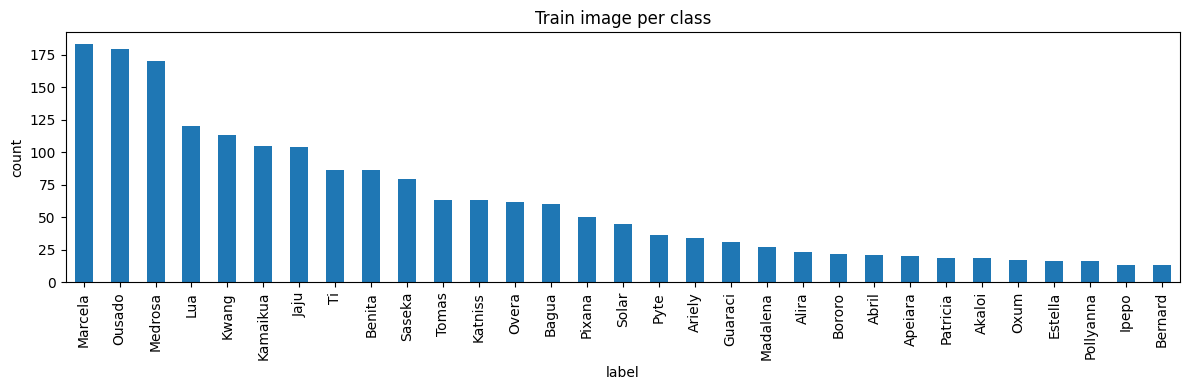

In [8]:
# plot
import matplotlib.pyplot as plt

counts.sort_values(ascending=False).plot(kind="bar", figsize=(12, 4))
plt.title("Train image per class")
plt.ylabel("count")
plt.tight_layout()
plt.show()

In [9]:
# load test pairs and validate the referenced images
test_pairs = pd.read_csv(TEST_CSV)
print("test columns:", test_pairs.columns.tolist())
test_pairs.head()

test columns: ['row_id', 'query_image', 'gallery_image']


,row_id,query_image,gallery_image
0,0,test_0001.png,test_0002.png
1,1,test_0001.png,test_0003.png
2,2,test_0001.png,test_0004.png
3,3,test_0001.png,test_0005.png
4,4,test_0001.png,test_0006.png


In [10]:
test_pairs["query_path"] = test_pairs["query_image"].apply(lambda f: TEST_IMG_DIR / str(f))
test_pairs["gallery_path"] = test_pairs["gallery_image"].apply(lambda f: TEST_IMG_DIR / str(f))

missing_q = test_pairs[~test_pairs["query_path"].apply(lambda p: p.exists())]
missing_g = test_pairs[~test_pairs["gallery_path"].apply(lambda p: p.exists())]

print("Test rows:", len(test_pairs))
print("Missing query images:", len(missing_q))
print("Missing gallery images:", len(missing_g))

missing_q.head(5), missing_g.head(5)

Test rows: 137270
Missing query images: 0
Missing gallery images: 0


(Empty DataFrame
 Columns: [row_id, query_image, gallery_image, query_path, gallery_path]
 Index: [],
 Empty DataFrame
 Columns: [row_id, query_image, gallery_image, query_path, gallery_path]
 Index: [])

In [11]:
# unique test image list
unique_test_images = pd.unique(pd.concat([
    test_pairs["query_image"].astype(str),
    test_pairs["gallery_image"].astype(str),
]))
unique_test_images = sorted(unique_test_images.tolist())

print("Unique test images:", len(unique_test_images))
unique_test_images[:10]

Unique test images: 371


['test_0001.png',
 'test_0002.png',
 'test_0003.png',
 'test_0004.png',
 'test_0005.png',
 'test_0006.png',
 'test_0007.png',
 'test_0008.png',
 'test_0009.png',
 'test_0010.png']

In [12]:
OUT_DIR = DATA_ROOT / "labels" / "processed"
OUT_DIR.mkdir(parents=True, exist_ok=True)

train_index = train[["filename", "label"]].copy()
train_index.to_csv(OUT_DIR / "train_index.csv", index=False)

pd.DataFrame({"filename": unique_test_images}).to_csv(OUT_DIR / "test_unique_images.csv", index=False)

test_pairs.to_csv(OUT_DIR / "test_pairs.csv", index=False)

print("Wrote:")
print(" --", (OUT_DIR / "train_index.csv").as_posix())
print(" --", (OUT_DIR / "test_unique_images.csv").as_posix())
print(" --", (OUT_DIR / "test_pairs.csv").as_posix())

Wrote:
 -- ../data/labels/processed/train_index.csv
 -- ../data/labels/processed/test_unique_images.csv
 -- ../data/labels/processed/test_pairs.csv


In [13]:
# Collect Image Size Metadata
def collect_image_sizes(paths, max_samples=None):
    rows = []

    if max_samples is not None:
        paths = paths[:max_samples]

    for p in tqdm(paths):
        try:
            with Image.open(p) as img:
                w, h = img.size
                rows.append((w, h, w/h))
        except:
            continue

    return pd.DataFrame(rows, columns=["width", "height", "aspect"])

In [14]:
# Train Image Sizes
train_paths = train["path"].tolist()
train_meta = collect_image_sizes(train_paths)

print("Train image stats:")
display(train_meta.describe())

100%|██████████| 1895/1895 [00:00<00:00, 3565.37it/s]

Train image stats:


,width,height,aspect
count,1895.000000,1895.000000,1895.000000
mean,3202.748813,2079.336675,1.740649
std,1547.408631,970.915014,1.013378
min,308.000000,247.000000,0.362273
25%,1937.000000,1276.500000,1.117258
50%,3275.000000,2072.000000,1.540382
75%,4375.000000,2832.500000,1.986570
max,6932.000000,4450.000000,9.370844


In [16]:
# Test image sizes
test_paths = [(TEST_IMG_DIR / f) for f in unique_test_images]
test_meta = collect_image_sizes(test_paths)

print("Test image stats:")
display(test_meta.describe())

100%|██████████| 371/371 [00:00<00:00, 2729.04it/s]

Test image stats:


,width,height,aspect
count,371.000000,371.000000,371.000000
mean,3179.428571,1990.708895,1.819533
std,1535.509239,988.410803,1.024822
min,193.000000,176.000000,0.461722
25%,1963.000000,1180.500000,1.182067
50%,3217.000000,1949.000000,1.550607
75%,4364.500000,2704.500000,2.191119
max,6912.000000,4616.000000,7.285714


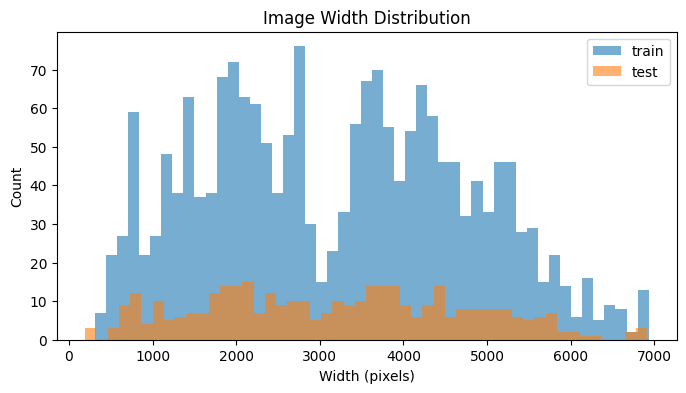

In [17]:
# Plot Distributions
plt.figure(figsize=(8,4))
plt.hist(train_meta["width"], bins=50, alpha=0.6, label="train")
plt.hist(test_meta["width"], bins=50, alpha=0.6, label="test")
plt.title("Image Width Distribution")
plt.xlabel("Width (pixels)")
plt.ylabel("Count")
plt.legend()
plt.show()

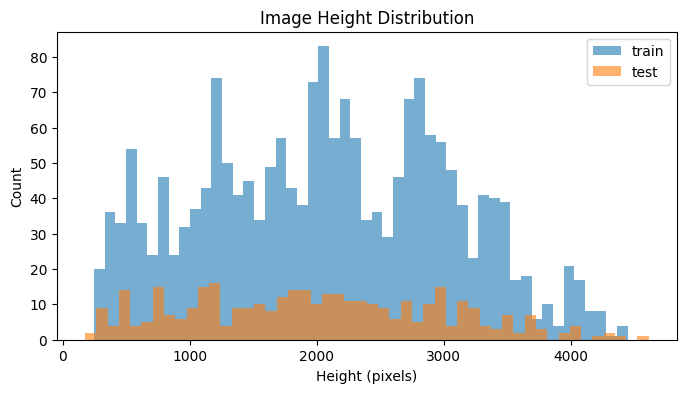

In [18]:
plt.figure(figsize=(8,4))
plt.hist(train_meta["height"], bins=50, alpha=0.6, label="train")
plt.hist(test_meta["height"], bins=50, alpha=0.6, label="test")
plt.title("Image Height Distribution")
plt.xlabel("Height (pixels)")
plt.ylabel("Count")
plt.legend()
plt.show()

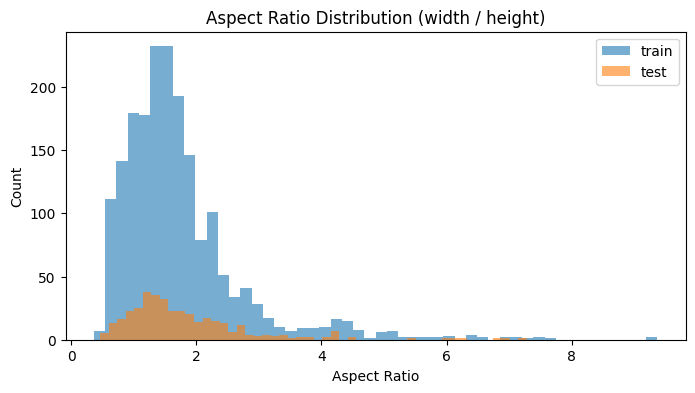

In [19]:
plt.figure(figsize=(8,4))
plt.hist(train_meta["aspect"], bins=50, alpha=0.6, label="train")
plt.hist(test_meta["aspect"], bins=50, alpha=0.6, label="test")
plt.title("Aspect Ratio Distribution (width / height)")
plt.xlabel("Aspect Ratio")
plt.ylabel("Count")
plt.legend()
plt.show()

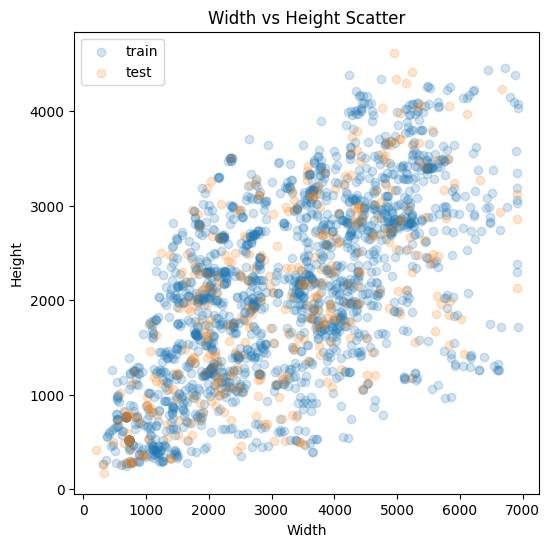

In [20]:
plt.figure(figsize=(6,6))
plt.scatter(train_meta["width"], train_meta["height"], alpha=0.2, label="train")
plt.scatter(test_meta["width"], test_meta["height"], alpha=0.2, label="test")
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Width vs Height Scatter")
plt.legend()
plt.show()